In [1]:
# Experiment on Thyroid dataset
# https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/new-thyroid.data


import pandas as pd
import numpy as np
import os, sys
import time

from matplotlib import pyplot as plt

sys.path.append("src")
from DIMVImputation import DIMVImputation

In [2]:
# load thyroid dataset 
def load_thyroid()-> pd.DataFrame:
    URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/thyroid-disease/new-thyroid.data"
    df = pd.read_csv(URL, header=None)
    
    X, y = df.iloc[:, 1:], df.iloc[:, 0]
    X, y = X.to_numpy(), y.to_numpy()
    return X, y

In [3]:
# Emulate missing dataset
def emulate_missing(X: np.ndarray, rate:float)-> np.ndarray:
    # Number of entry in X:
    N, P = X.shape
    E = N * P
    
    # Number of missing entry
    M = int(E * rate)
    
    # Index of missing entry
    idx = np.random.choice(E, M)
    
    X_miss = X.reshape(E, -1)
    X_miss[idx] = np.nan
    X_miss = X_miss.reshape(N, P)
    
    # Compute number of row with all entry missing
    n = np.isnan(X_miss).all(-1).sum()
    
    # if n > 0:
    #     return emulate_missing(X, rate)
    
    return X_miss

In [4]:
def rmse_calc(ori_data, imp_data, missing_mask):
    """
    missing_mask: 1 is missing_data, 0 is observed_data
    Args: 
        ori_data (np.ndarray): original non missing data 
        imp_data (np.ndarray): imputed data 
        missing_mask (np.ndarray): 1 is missing_data, 0 is observed_data 
    Return:
        np.ndarray: RMSE between original data (ground truth) and the imputed data 
    """

    nominator = np.sum(
            (missing_mask * ori_data \
                    - missing_mask * imp_data
             ) ** 2
            )
    denominator = np.sum(missing_mask)

    return np.sqrt(nominator / denominator)

In [5]:
# Experiment
X, y = load_thyroid()

rs = []
for i in range(50):
    for r in np.linspace(.1, .8, 15):
        try:
            X_miss = emulate_missing(X, r)

            # Mask to compute rmse
            mask = np.isnan(X_miss)

            dper_imputer = DIMVImputation(complete_case=False)
            comp_imputer = DIMVImputation(complete_case=True)

            # impute with dper DIMV
            t0 = time.time()
            dper_imputer.fit(X_miss, initializing=True, n_jobs=-1)
            X_imp_dper = dper_imputer.transform(X_miss)
            t0 = time.time() - t0

            # Evaluating rmse
            rmse_0 = rmse_calc(X, X_imp_dper, mask)


            # impute with complete case DIMV
            t1 = time.time()
            comp_imputer.fit(X_miss, initializing=True, n_jobs=-1)
            X_imp_comp = comp_imputer.transform(X_miss)
            t1 = time.time() - t1

            # Evaluating rmse
            rmse_1 = rmse_calc(X, X_imp_comp, mask)

            rs.append((i, r, t0, t1, rmse_0, rmse_1))
        except:
            pass

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3990.02it/s]
/home/iamtu/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/iamtu/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/iamtu/codes/DIMVImputation/src/DIMVImputation.py:55: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov = np.cov(X_complete, rowvar=False)
/home/iamtu/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/iamtu/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
100%|█████████████████████████████████

In [7]:
rs = pd.DataFrame(rs, columns=["trial", "missing_rate", "dper_runtime", "completecase_runtime", "rmse_dper", "rmse_competecases"])

In [14]:
result = pd.pivot_table(
    rs, 
    index = "missing_rate",
    values = ["rmse_dper", "rmse_competecases"],
    aggfunc = [np.mean, np.std])

result

result = result.iloc[[0, 2, 4, 6, 8, 10, 12 , 14],:]
result

mean                          std           
             rmse_competecases  rmse_dper rmse_competecases  rmse_dper
missing_rate                                                          
0.1                  20.141419   6.543302          7.115309   1.228633
0.2                  19.071348   6.691147          6.950850   1.035995
0.3                  19.291771   6.648136          5.993240   0.791557
0.4                  22.109473   6.940665          9.414448   0.637856
0.5                  28.604029   7.433084         16.684764   1.506105
0.6                  65.199582   7.387933        117.667723   0.730753
0.7                 114.325706  10.087843        147.063940  10.195272
0.8                 173.699164  10.015401        409.398851   6.142359

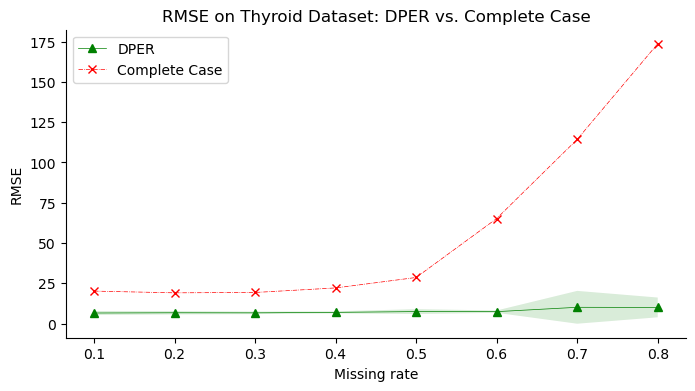

In [33]:
# DPER
fig, ax = plt.subplots(figsize = [8, 4])
ax.plot(
    result.index,
    result["mean"].rmse_dper,
    label = "DPER",
    lw = .5, 
    c="green",
    marker="^"
)

ax.fill_between(
    result.index,
    result["mean"].rmse_dper - result["std"].rmse_dper,
    result["mean"].rmse_dper + result["std"].rmse_dper,
    alpha = .15,
    color = "green",
    edgecolor="None"

)

ax.plot(
    result.index,
    result["mean"].rmse_competecases,
    label = "Complete Case",
    lw = .5, 
    ls = "-.",
    c="red",
    marker="x"
)

ax.legend()
ax.set_xlabel("Missing rate")
ax.set_ylabel("RMSE")
ax.set_title("RMSE on Thyroid Dataset: DPER vs. Complete Case")
ax.spines[["top", "right"]].set_visible(False)

fig.savefig("figure.png")

# plt.fill_between(
#     result.index,
#     result["mean"].rmse_competecases - result["std"].rmse_competecases,
#     result["mean"].rmse_competecases + result["std"].rmse_competecases,
#     alpha = .15,
#     color = "red",
#     edgecolor="None"

# )
